In [1]:
import sys
sys.path.append('../')
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from scipy.stats import norm
from scipy.optimize import newton
from pynverse import inversefunc
import warnings
warnings.filterwarnings("ignore")

def gamma(x,mu_0,mu_1,sigma_0,sigma_1,alpha):
    return 1/((norm.pdf(x, loc=mu_0, scale=sigma_0)/norm.pdf(x, loc=mu_1, scale=sigma_1))*(1/alpha -1 )+1)

def gamma_1(x,mu_0,mu_1,sigma_0,sigma_1,alpha):
    return (norm.pdf(x, loc=mu_0, scale=sigma_0)/norm.pdf(x, loc=mu_1, scale=sigma_1))*(1/alpha -1 )+1

def P_evidence(x,alpha,mu_0,mu_1,sigma_0,sigma_1):
    return alpha * norm.pdf(x, loc=mu_1, scale=sigma_1)+(1-alpha)*norm.pdf(x, loc=mu_0, scale=sigma_0)

# feasible pairs that satisfy DP 
def f_dp(x,alpha_aa,alpha_c,mu_c1,sigma_c1,mu_c0,sigma_c0,mu_aa1,sigma_aa1,mu_aa0,sigma_aa0):
  	f_c = (lambda x_c: alpha_c * norm.cdf(x_c, loc=mu_c1, scale=sigma_c1)+(1-alpha_c)*norm.cdf(x_c,loc=mu_c0, scale=sigma_c0))
  	inv_f_c = inversefunc(f_c)
  	return float(inv_f_c( alpha_aa * norm.cdf(x, loc=mu_aa1, scale=sigma_aa1)+(1-alpha_aa)*norm.cdf(x, loc=mu_aa0, scale=sigma_aa0)))

def Pdp_aa(x,alpha_aa,mu_aa1,sigma_aa1,mu_aa0,sigma_aa0):
    return alpha_aa * norm.pdf(x, loc=mu_aa1, scale=sigma_aa1)+(1-alpha_aa)*norm.pdf(x, loc=mu_aa0, scale=sigma_aa0)

def Pdp_c(x,alpha_c,mu_c1,sigma_c1,mu_c0,sigma_c0):
    return alpha_c * norm.pdf(x, loc=mu_c1, scale=sigma_c1)+(1-alpha_c)*norm.pdf(x, loc=mu_c0, scale=sigma_c0)

# feasible pairs that satisfy EqOpt

def f_eqopt(x,alpha_aa,alpha_c,mu_c1,sigma_c1,mu_c0,sigma_c0,mu_aa1,sigma_aa1,mu_aa0,sigma_aa0):
  	return norm.ppf(norm.cdf(x, loc=mu_aa1, scale=sigma_aa1),loc=mu_c1, scale=sigma_c1)

def Peqopt_aa(x,alpha_aa,mu_aa1,sigma_aa1,mu_aa0,sigma_aa0):
    return norm.pdf(x, loc=mu_aa1, scale=sigma_aa1)

def Peqopt_c(x,alpha_c,mu_c1,sigma_c1,mu_c0,sigma_c0):
    return norm.pdf(x, loc=mu_c1, scale=sigma_c1)

# optimal equation for finding optimal solution
def balanced_eqn_fn(x, alpha_aa,alpha_c, fn, Pf_aa, Pf_c,paa, pc,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,mu_c0,mu_c1,sigma_c0,sigma_c1,b_c):
    x_aa = x
    x_c = fn(x,alpha_aa,alpha_c,mu_c1,sigma_c1,mu_c0,sigma_c0,mu_aa1,sigma_aa1,mu_aa0,sigma_aa0)
    return paa*(gamma(x,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,alpha_aa)-1/(b_c+1))*P_evidence(x,alpha_aa,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1)/Pf_aa(x,alpha_aa,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1)+pc*(gamma(x_c,mu_c0,mu_c1,sigma_c0,sigma_c1,alpha_c)-1/(b_c+1))*P_evidence(x_c,alpha_c,mu_c0,mu_c1,sigma_c0,sigma_c1)/Pf_c(x_c,alpha_c,mu_c0,mu_c1,sigma_c0,sigma_c1)


def balanced_eqn_un(x, mu_0,mu_1,sigma_0,sigma_1,alpha,b_c):
    return gamma_1(x,mu_0,mu_1,sigma_0,sigma_1,alpha) - (b_c+1)


def get_policy_fn(alpha_aa, alpha_c, paa, pc,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,mu_c0,mu_c1,sigma_c0,sigma_c1,b_c,fn, Pf_aa, Pf_c):
    root=[]
    for i in np.arange(min(mu_aa0,mu_c0),max(mu_aa1,mu_c1),1):
        try:
            root.append(newton(balanced_eqn_fn, 
                               x0 = i, 
                               maxiter=50, 
                               args = (alpha_aa,alpha_c, fn, Pf_aa, Pf_c,paa, pc,
                                       mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,mu_c0,mu_c1,sigma_c0,sigma_c1,b_c)))
        except(RuntimeError):
            pass

    root = [float(format(round(r, 4))) for r in root]

    return np.unique(root)[0],fn(np.unique(root)[0],alpha_aa,alpha_c,mu_c1,sigma_c1,mu_c0,sigma_c0,mu_aa1,sigma_aa1,mu_aa0,sigma_aa0),len(np.unique(root)),np.unique(root)[0]


def get_policy_un(alpha_aa,alpha_c, paa, pc,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,mu_c0,mu_c1,sigma_c0,sigma_c1,b_c,fn, Pf_aa, Pf_c):
    root_aa=[]
    root_c=[]
    for i in np.arange(min(mu_aa0,mu_c0),max(mu_aa1,mu_c1),1):
        try:
            root_aa.append(newton(balanced_eqn_un,x0 = i,maxiter=50,args = (mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,alpha_aa,b_c)))
        except(RuntimeError):
            pass

        try:
            root_c.append(newton(balanced_eqn_un,x0 = i,maxiter=50,args = (mu_c0,mu_c1,sigma_c0,sigma_c1,alpha_c,b_c)))
        except(RuntimeError):
            pass

    root_aa = [float(format(round(r, 4))) for r in root_aa]
    root_c = [float(format(round(r, 4))) for r in root_c]  

    return np.unique(root_aa)[0],np.unique(root_c)[0],len(np.unique(root_aa)),len(np.unique(root_aa))


def eva_policy(theta_aa,theta_c,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,mu_c0,mu_c1,sigma_c0,sigma_c1):
    tpr = []
    fpr = []

    tpr.append(1-norm.cdf(theta_aa, loc=mu_aa1, scale=sigma_aa1)) 
    tpr.append(1-norm.cdf(theta_c, loc=mu_c1, scale=sigma_c1))

    fpr.append(1-norm.cdf(theta_aa,loc=mu_aa0, scale=sigma_aa0))
    fpr.append(1-norm.cdf(theta_c, loc=mu_c0, scale=sigma_c0))

    return tpr,fpr


def eva_classifier_fn(alpha_aa,alpha_c,policy,paa, pc,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,mu_c0,mu_c1,sigma_c0,sigma_c1,b_c,fn, Pf_aa, Pf_c):
    if policy == 'UN' :
        theta_aa, theta_c, _ , _ = get_policy_un(alpha_aa,alpha_c,paa, pc,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,mu_c0,mu_c1,sigma_c0,sigma_c1,b_c, fn, Pf_aa, Pf_c)

    else:
        theta_aa, theta_c, _ , _ = get_policy_fn(alpha_aa, alpha_c, paa, pc,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,mu_c0,mu_c1,sigma_c0,sigma_c1,b_c, fn, Pf_aa, Pf_c)
    return eva_policy(theta_aa,theta_c,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,mu_c0,mu_c1,sigma_c0,sigma_c1)


# Long term impacts of fairness constraints for Gaussian distributed Synthetic data

## 1. Evolution behavior and equilibrium demonstration

Parameter specifications for two groups $G_{aa}$ and $G_c$: 
1. $X_t\mid Y_t=y,S=s \sim N(\mu_{sy},\sigma_{sy}^2)$, $\mu_{sy} =$ mu_sy and $\sigma_{sy} =$ sigma_sy, $s \in \{aa,c\}$. 
2. $P(S=aa) = $Paa and $P(S=c) = $1-Paa.
3. benefit cost ratio $\frac{b}{c} =$ b_c is the same for two groups. 

In [123]:
b_c = 1
mu_aa1,mu_aa0,mu_c1,mu_c0 = 5,-5,5,-5
sigma_aa1,sigma_aa0,sigma_c1,sigma_c0 = 5,5,5,5
Paa = 0.5
Pc = 1-Paa

### Evolution of qualification rates and Balanced curves

Generate transition $P(Y_{t+1}=1\mid Y_t = y, A_t = a,S=s) = T[y,a,s]$; $s = 0$ corresponds to $G_{aa}$, $s=1$ corresponds to $G_c$. 

Dynamics for updating qualification rate $\alpha^s_t$

In [2]:
def update(alpha,tpr,fpr,T, group):
    g0 = T[0,0,group]*(1-fpr[group]) + T[0,1,group]*fpr[group]
    g1 = T[1,0,group]*(1-tpr[group]) + T[1,1,group]*tpr[group]
    return alpha*g1 + (1-alpha)*g0

def balance_diff(alpha,tpr,fpr,T, group):
    g0 = T[0,0,group]*(1-fpr[group]) + T[0,1,group]*fpr[group]
    g1 = T[1,0,group]*(1-tpr[group]) + T[1,1,group]*tpr[group]    
    return g0 + (g1-g0-1)*alpha 

def update_qualification_rates(alpha_aa, alpha_c, T, policy,paa, pc,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,mu_c0,mu_c1,sigma_c0,sigma_c1,b_c,fn=None, Pf_aa=None, Pf_c=None):
    
    tpr,fpr = eva_classifier_fn(alpha_aa,alpha_c, policy,paa, pc,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,mu_c0,mu_c1,sigma_c0,sigma_c1,b_c,fn, Pf_aa, Pf_c)  
    
    alpha_aa_next = update(alpha_aa,tpr,fpr,T,group = 0)
    alpha_c_next = update(alpha_c,tpr,fpr,T,group = 1)
    return alpha_aa_next,alpha_c_next


def compute_balance_diff(alpha_aa, alpha_c, T, policy, paa, pc, mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,mu_c0,mu_c1,sigma_c0,sigma_c1,b_c,fn=None, Pf_aa=None, Pf_c=None):
    
    tpr,fpr = eva_classifier_fn(alpha_aa,alpha_c,policy,paa,pc,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,mu_c0,mu_c1,sigma_c0,sigma_c1,b_c,fn, Pf_aa, Pf_c)    
    group0 = balance_diff(alpha_aa,tpr,fpr,T,group=0)
    group1 = balance_diff(alpha_c,tpr,fpr,T,group=1)
    return group0, group1

### UN case：Evolution behavior 

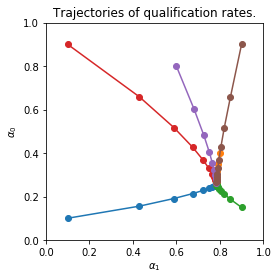

In [57]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 10

T = np.zeros((2, 2, 2))

# unique equilibrium
T[0,0,0] = 0.1 # "AA"
T[0,1,0] = 0.5
T[1,0,0] = 0.5
T[1,1,0] = 0.7

T[0,0,1] = 0.4  # C
T[0,1,1] = 0.5
T[1,0,1] = 0.5
T[1,1,1] = 0.9

plt.figure()
plt.axis('square')
t=-1
alpha0List = [0.1,0.4,0.15,0.9,0.8,0.9]
alpha1List = [0.1,0.8,0.9,0.1,0.6,0.9]
while t < 5:
    t+=1
    alpha0, alpha1 = alpha0List[t],alpha1List[t]
    alpha0_un_evolution=[alpha0]
    alpha1_un_evolution=[alpha1]
    for _ in range(MAX_ITERATION_EQUILIBRIUM):
        alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, T, 'UN', Paa, Pc,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,mu_c0,mu_c1,sigma_c0,sigma_c1,b_c,fn=None, Pf_aa=None, Pf_c=None)
        alpha0_un_evolution.append(alpha0)
        alpha1_un_evolution.append(alpha1)


    plt.plot(alpha1_un_evolution,alpha0_un_evolution,'o-')
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.xlabel(r'$\alpha_1$')
plt.ylabel(r'$\alpha_0$')
plt.title("Trajectories of qualification rates.")
plt.show()

### Balanced curves

In [ ]:
TOTAL_STEP = 100
alphaList = np.linspace(0.05,0.95,TOTAL_STEP)

group0_UN = np.zeros([len(alphaList),len(alphaList)])
group1_UN = np.zeros([len(alphaList),len(alphaList)])

for i, alpha0 in enumerate(alphaList):
    for j, alpha1 in enumerate(alphaList):
        sys.stdout.write("\r{0}%".format(str((i*TOTAL_STEP + j)*100/(TOTAL_STEP*TOTAL_STEP))))
        group0_UN[i,j],group1_UN[i,j] = compute_balance_diff(alpha0, alpha1, T, 'UN', Paa, Pc,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,mu_c0,mu_c1,sigma_c0,sigma_c1,b_c,fn=None, Pf_aa=None, Pf_c=None)

        
vmin=np.min([group0_UN,group1_UN])
vmax=z_max=np.max([group0_UN,group1_UN])
np.savetxt('group0_map_un.txt',group0_UN, fmt="%f")
np.savetxt('group1_map_un.txt',group1_UN, fmt="%f")

fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(8, 4))

im0 = ax0.pcolormesh(group0_UN, cmap='gist_rainbow',vmin=vmin,vmax=vmax)
im1= ax1.pcolormesh(group1_UN, cmap='gist_rainbow',vmin=vmin,vmax=vmax)

fig.colorbar(im1, ax=ax1)
plt.show()

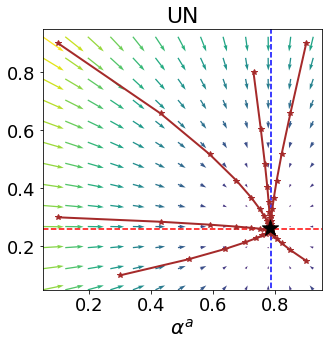

In [59]:
TOTAL_STEP = 100
alphaList = np.linspace(0.05,0.95,TOTAL_STEP)
group0_un = np.loadtxt('group0_map_un.txt')
group1_un = np.loadtxt('group1_map_un.txt')

idx1 = np.argmin(np.abs(group1_un),axis=1)
idx0 = np.argmin(np.abs(group0_un),axis=0)
alphaList_group1 = [alphaList[i] for i in idx1]
alphaList_group0 = [alphaList[i] for i in idx0]
idx = [*range(0,len(alphaList_group1),12)]

alphaList_ex1 = [alphaList_group1[j] for j in idx]
alphaList_ex0 = [alphaList_group0[j] for j in idx]
alphaList_ex = [alphaList[j] for j in idx]

alpha_interpList = list(np.arange(0,1,0.001))
balance_curve1 = np.interp(alpha_interpList,alphaList_ex,alphaList_ex1)
balance_curve0 = np.interp(alpha_interpList,alphaList_ex,alphaList_ex0)

STEP = 8
alpha0,alpha1 = np.meshgrid(alphaList[0::STEP],alphaList[0::STEP])
M = np.hypot(group1_un[0::STEP,0::STEP],group0_un[0::STEP,0::STEP])

fig, ax = plt.subplots(figsize=(5, 4.8))
ax.plot(balance_curve1,alpha_interpList,'b--')
ax.plot(alpha_interpList,balance_curve0,'r--')
ax.set_xlim(0.05,0.95)
ax.set_ylim(0.05,0.95)
Q = ax.quiver(alpha0,alpha1,group1_un[0::STEP,0::STEP],group0_un[0::STEP,0::STEP],M)

t=-1
alpha0List = [0.3,0.1,0.15,0.9,0.8,0.9]
alpha1List = [0.1,0.3,0.9,0.1,0.73,0.9]
while t < 5:
    t+=1
    alpha0, alpha1 = alpha0List[t],alpha1List[t]
    alpha0_un_evolution=[alpha0]
    alpha1_un_evolution=[alpha1]
    for _ in range(MAX_ITERATION_EQUILIBRIUM):
        alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, T, 'UN', Paa, Pc,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,mu_c0,mu_c1,sigma_c0,sigma_c1,b_c,fn=None, Pf_aa=None, Pf_c=None)
        alpha0_un_evolution.append(alpha0)
        alpha1_un_evolution.append(alpha1)


    plt.plot(alpha1_un_evolution,alpha0_un_evolution,'*-',color='brown',linewidth=2)

ax.scatter(alpha1_un_evolution[-1]-0.001,alpha0_un_evolution[-1],s=17**2,marker='*', facecolor='k',zorder=3)


ax.set_xlabel(r'$\alpha^a$',fontsize=20)
#ax.set_ylabel(r'$\alpha^b$',fontsize=14)
ax.set_title('UN',fontsize=22)
ax.tick_params(axis='both', labelsize=18)
ax.xaxis.set_ticks(np.arange(0.2, 0.8, 0.2))
ax.yaxis.set_ticks(np.arange(0.2, 0.8, 0.2))
fig.savefig('UN1.eps', bbox_inches='tight')
plt.show()

### EqOpt case: Evolution behavior

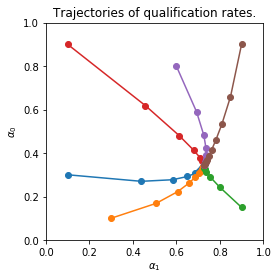

In [124]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 10


T = np.zeros((2, 2, 2))

# unique equilibrium
T[0,0,0] = 0.1 # "AA"
T[0,1,0] = 0.5
T[1,0,0] = 0.5
T[1,1,0] = 0.7

T[0,0,1] = 0.4  # C
T[0,1,1] = 0.5
T[1,0,1] = 0.5
T[1,1,1] = 0.9

plt.figure()
plt.axis('square')
t=-1
alpha0List = [0.3,0.1,0.15,0.9,0.8,0.9]
alpha1List = [0.1,0.3,0.9,0.1,0.6,0.9]
while t < 5:
    t+=1
    alpha0, alpha1 = alpha0List[t],alpha1List[t]
    alpha0_eqopt_evolution=[alpha0]
    alpha1_eqopt_evolution=[alpha1]
    for _ in range(MAX_ITERATION_EQUILIBRIUM):
        alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, T, 'EqOpt', Paa, Pc,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,mu_c0,mu_c1,sigma_c0,sigma_c1,b_c,f_eqopt, Peqopt_aa, Peqopt_c)
        alpha0_eqopt_evolution.append(alpha0)
        alpha1_eqopt_evolution.append(alpha1)


    plt.plot(alpha1_eqopt_evolution,alpha0_eqopt_evolution,'o-')
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.xlabel(r'$\alpha_1$')
plt.ylabel(r'$\alpha_0$')
plt.title("Trajectories of qualification rates.")
plt.show()

### Balanced curves

In [ ]:
TOTAL_STEP = 100
alphaList = np.linspace(0.05,0.95,TOTAL_STEP)

group0_Eqopt = np.zeros([len(alphaList),len(alphaList)])
group1_Eqopt = np.zeros([len(alphaList),len(alphaList)])

for i, alpha0 in enumerate(alphaList):
    for j, alpha1 in enumerate(alphaList):
        sys.stdout.write("\r{0}%".format(str((i*TOTAL_STEP + j)*100/(TOTAL_STEP*TOTAL_STEP))))
        group0_Eqopt[i,j],group1_Eqopt[i,j] = compute_balance_diff(alpha0, alpha1, T, 'EqOpt', Paa, Pc,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,mu_c0,mu_c1,sigma_c0,sigma_c1,b_c,f_eqopt, Peqopt_aa, Peqopt_c)

#np.savetxt('group0_map1.txt',group0_Eqopt, fmt="%f")
#np.savetxt('group1_map1.txt',group1_Eqopt, fmt="%f")
        
vmin=np.min([group0_Eqopt,group1_Eqopt])
vmax=z_max=np.max([group0_Eqopt,group1_Eqopt])

fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(8, 4))

im0 = ax0.pcolormesh(group0_Eqopt, cmap='gist_rainbow',vmin=vmin,vmax=vmax)
im1= ax1.pcolormesh(group1_Eqopt, cmap='gist_rainbow',vmin=vmin,vmax=vmax)

fig.colorbar(im1, ax=ax1)
plt.show()

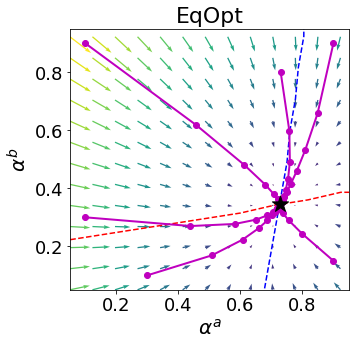

In [60]:

TOTAL_STEP = 100
alphaList = np.linspace(0.05,0.95,TOTAL_STEP)
group0_Eqopt = np.loadtxt('group0_map1.txt')
group1_Eqopt = np.loadtxt('group1_map1.txt')

idx1 = np.argmin(np.abs(group1_Eqopt),axis=1)
idx0 = np.argmin(np.abs(group0_Eqopt),axis=0)
alphaList_group1 = [alphaList[i] for i in idx1]
alphaList_group0 = [alphaList[i] for i in idx0]
idx = [*range(0,len(alphaList_group1),12)]

alphaList_ex1 = [alphaList_group1[j] for j in idx]
alphaList_ex0 = [alphaList_group0[j] for j in idx]
alphaList_ex = [alphaList[j] for j in idx]

alpha_interpList = list(np.arange(0,1,0.001))
balance_curve1 = np.interp(alpha_interpList,alphaList_ex,alphaList_ex1)
balance_curve0 = np.interp(alpha_interpList,alphaList_ex,alphaList_ex0)

STEP = 8
alpha0,alpha1 = np.meshgrid(alphaList[0::STEP],alphaList[0::STEP])
M = np.hypot(group1_Eqopt[0::STEP,0::STEP],group0_Eqopt[0::STEP,0::STEP])

fig, ax = plt.subplots(figsize=(5, 4.8))
ax.plot(balance_curve1,alpha_interpList,'b--')
ax.plot(alpha_interpList,balance_curve0,'r--')
ax.set_xlim(0.05,0.95)
ax.set_ylim(0.05,0.95)
Q = ax.quiver(alpha0,alpha1,group1_Eqopt[0::STEP,0::STEP],group0_Eqopt[0::STEP,0::STEP],M)

t=-1
alpha0List = [0.3,0.1,0.15,0.9,0.8,0.9]
alpha1List = [0.1,0.3,0.9,0.1,0.73,0.9]
while t < 5:
    t+=1
    alpha0, alpha1 = alpha0List[t],alpha1List[t]
    alpha0_eqopt_evolution=[alpha0]
    alpha1_eqopt_evolution=[alpha1]
    for _ in range(MAX_ITERATION_EQUILIBRIUM):
        alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, T, 'EqOpt', Paa, Pc,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,mu_c0,mu_c1,sigma_c0,sigma_c1,b_c,f_eqopt, Peqopt_aa, Peqopt_c)
        alpha0_eqopt_evolution.append(alpha0)
        alpha1_eqopt_evolution.append(alpha1)

    plt.plot(alpha1_eqopt_evolution,alpha0_eqopt_evolution,'o-',color='m',linewidth=2)
ax.scatter(alpha1_eqopt_evolution[-1]-0.001,alpha0_eqopt_evolution[-1],s=17**2,marker='*', facecolor='k',zorder=3)


ax.set_xlabel(r'$\alpha^a$',fontsize=20)
ax.set_ylabel(r'$\alpha^b$',fontsize=20)
ax.set_title('EqOpt',fontsize=22)
ax.tick_params(axis='both', labelsize=18)
ax.xaxis.set_ticks(np.arange(0.2, 0.8, 0.2))
ax.yaxis.set_ticks(np.arange(0.2, 0.8, 0.2))
fig.savefig('EqOpt1.eps', bbox_inches='tight')
plt.show()


### DP case: Evolution behavior

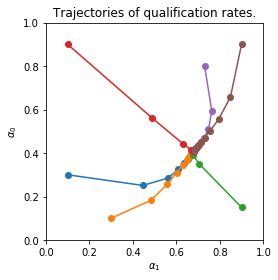

In [125]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 10

T = np.zeros((2, 2, 2))

# unique equilibria
T[0,0,0] = 0.1 # "AA"
T[0,1,0] = 0.5
T[1,0,0] = 0.5
T[1,1,0] = 0.7

T[0,0,1] = 0.4  # C
T[0,1,1] = 0.5
T[1,0,1] = 0.5
T[1,1,1] = 0.9

plt.figure()
plt.axis('square')
t=-1
alpha0List = [0.3,0.1,0.15,0.9,0.8,0.9]
alpha1List = [0.1,0.3,0.9,0.1,0.73,0.9]
while t < 5:
    t+=1
    alpha0, alpha1 = alpha0List[t],alpha1List[t]
    alpha0_dp_evolution=[alpha0]
    alpha1_dp_evolution=[alpha1]
    for _ in range(MAX_ITERATION_EQUILIBRIUM):
        alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, T, 'DP', Paa, Pc,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,mu_c0,mu_c1,sigma_c0,sigma_c1,b_c,f_dp, Pdp_aa, Pdp_c)
        alpha0_dp_evolution.append(alpha0)
        alpha1_dp_evolution.append(alpha1)


    plt.plot(alpha1_dp_evolution,alpha0_dp_evolution,'o-')
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.xlabel(r'$\alpha_1$')
plt.ylabel(r'$\alpha_0$')
plt.title("Trajectories of qualification rates.")
plt.show()

### Balanced curves

In [ ]:
TOTAL_STEP = 100
alphaList = np.linspace(0.05,0.95,TOTAL_STEP)

group0_dp = np.zeros([len(alphaList),len(alphaList)])
group1_dp = np.zeros([len(alphaList),len(alphaList)])

for i, alpha0 in enumerate(alphaList):
    for j, alpha1 in enumerate(alphaList):
        sys.stdout.write("\r{0}%".format(str((i*TOTAL_STEP + j)*100/(TOTAL_STEP*TOTAL_STEP))))
        group0_dp[i,j],group1_dp[i,j] = compute_balance_diff(alpha0, alpha1, T, 'DP', Paa, Pc,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,mu_c0,mu_c1,sigma_c0,sigma_c1,b_c,f_dp, Pdp_aa, Pdp_c)

np.savetxt('group0_map_dp.txt',group0_dp, fmt="%f")
np.savetxt('group1_map_dp.txt',group1_dp, fmt="%f")

vmin=np.min([group0_dp,group1_dp])
vmax=z_max=np.max([group0_dp,group1_dp])

fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(8, 4))

im0 = ax0.pcolormesh(group0_dp, cmap='gist_rainbow',vmin=vmin,vmax=vmax)
im1= ax1.pcolormesh(group1_dp, cmap='gist_rainbow',vmin=vmin,vmax=vmax)

fig.colorbar(im1, ax=ax1)
plt.show()

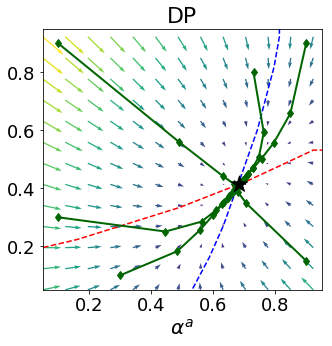

In [61]:
TOTAL_STEP = 100
alphaList = np.linspace(0.05,0.95,TOTAL_STEP)
group0_dp = np.loadtxt('group0_map_dp.txt')
group1_dp = np.loadtxt('group1_map_dp.txt')

idx1 = np.argmin(np.abs(group1_dp),axis=1)
idx0 = np.argmin(np.abs(group0_dp),axis=0)
alphaList_group1 = [alphaList[i] for i in idx1]
alphaList_group0 = [alphaList[i] for i in idx0]
idx = [*range(0,len(alphaList_group1),12)]

alphaList_ex1 = [alphaList_group1[j] for j in idx]
alphaList_ex0 = [alphaList_group0[j] for j in idx]
alphaList_ex = [alphaList[j] for j in idx]

alpha_interpList = list(np.arange(0,1,0.001))
balance_curve1 = np.interp(alpha_interpList,alphaList_ex,alphaList_ex1)
balance_curve0 = np.interp(alpha_interpList,alphaList_ex,alphaList_ex0)

STEP = 8
alpha0,alpha1 = np.meshgrid(alphaList[0::STEP],alphaList[0::STEP])
M = np.hypot(group1_dp[0::STEP,0::STEP],group0_dp[0::STEP,0::STEP])

fig, ax = plt.subplots(figsize=(5, 4.8))
ax.plot(balance_curve1,alpha_interpList,'b--')
ax.plot(alpha_interpList,balance_curve0,'r--')
ax.set_xlim(0.05,0.95)
ax.set_ylim(0.05,0.95)
Q = ax.quiver(alpha0,alpha1,group1_dp[0::STEP,0::STEP],group0_dp[0::STEP,0::STEP],M)

t=-1
alpha0List = [0.3,0.1,0.15,0.9,0.8,0.9]
alpha1List = [0.1,0.3,0.9,0.1,0.73,0.9]
while t < 5:
    t+=1
    alpha0, alpha1 = alpha0List[t],alpha1List[t]
    alpha0_dp_evolution=[alpha0]
    alpha1_dp_evolution=[alpha1]
    for _ in range(MAX_ITERATION_EQUILIBRIUM):
        alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, T, 'DP', Paa, Pc,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,mu_c0,mu_c1,sigma_c0,sigma_c1,b_c,f_dp, Pdp_aa, Pdp_c)
        alpha0_dp_evolution.append(alpha0)
        alpha1_dp_evolution.append(alpha1)

    plt.plot(alpha1_dp_evolution,alpha0_dp_evolution,'d-',color='darkgreen',linewidth=2)
ax.scatter(alpha1_dp_evolution[-1]-0.004,alpha0_dp_evolution[-1]-0.001,s=17**2,marker='*', facecolor='k',zorder=3)


ax.set_xlabel(r'$\alpha^a$',fontsize=20)
#ax.set_ylabel(r'$\alpha^b$',fontsize=14)
ax.set_title('DP',fontsize=22)
ax.tick_params(axis='both', labelsize=18)
ax.xaxis.set_ticks(np.arange(0.2, 0.8, 0.2))
ax.yaxis.set_ticks(np.arange(0.2, 0.8, 0.2))
fig.savefig('DP1.eps', bbox_inches='tight')
plt.show()


## 2. Demographic invariant distribution with different transitions

In [127]:
def transitionConB_invDist():
    T = np.zeros((2, 2, 2))
    T[0,0,0] = np.random.uniform(0,1,1) # "AA"
    T[0,1,0] = np.random.uniform(T[0,0,0],1,1)
    T[1,0,0] = np.random.uniform(0,1,1)
    T[1,1,0] = np.random.uniform(T[1,0,0],1,1)

    T[0,0,1] = np.random.uniform(0,1,1) # C
    T[0,1,1] = np.random.uniform(T[0,0,1],1,1)
    T[1,0,1] = np.random.uniform(0,1,1)
    T[1,1,1] = np.random.uniform(T[1,0,1],1,1)
    
    return T

def transitionConA_invDist():
    T = np.zeros((2, 2, 2))
    T[0,1,0] = np.random.uniform(0,1,1) # "AA"
    T[0,0,0] = np.random.uniform(T[0,1,0],1,1)
    T[1,1,0] = np.random.uniform(0,1,1)
    T[1,0,0] = np.random.uniform(T[1,1,0],1,1)

    T[0,1,1] = np.random.uniform(0,1,1) # C
    T[0,0,1] = np.random.uniform(T[0,1,1],1,1)
    T[1,1,1] = np.random.uniform(0,1,1)
    T[1,0,1] = np.random.uniform(T[1,1,1],1,1)
    
    return T

#### Comparison of equilibrium under UN, EqOpt, DP under Condition 1(A) or Condition 1(B)
1. Eqopt/DP always mitigate unfairness under Condition 1(B)
2. Eqopt/DP always excarbate unfairness under Condition 1(A)

In [128]:
mu_aa1,mu_aa0 = 5,-5
mu_c1,mu_c0 = mu_aa1,mu_aa0
sigma_aa1,sigma_aa0,sigma_c1,sigma_c0 = 5,5,5,5
Paa = 0.5
Pc = 1-Paa

#np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 10
inequality_un,inequality_eqopt,inequality_dp = [],[],[]
run = 0
b_c = 1
while run < 10:
    run += 1
    T = transitionConB_invDist()   
    #T = transitionConA_invDist() 
    alpha0_un, alpha1_un = 0.5,0.5
    alpha0_un_evolution=[alpha0_un]
    alpha1_un_evolution=[alpha1_un]

    alpha0_eqopt, alpha1_eqopt = 0.5,0.5
    alpha0_eqopt_evolution=[alpha0_eqopt]
    alpha1_eqopt_evolution=[alpha1_eqopt]

    alpha0_dp, alpha1_dp = 0.5,0.5
    alpha0_dp_evolution=[alpha0_dp]
    alpha1_dp_evolution=[alpha1_dp]
    
    for _ in range(MAX_ITERATION_EQUILIBRIUM):
        alpha0_un, alpha1_un = update_qualification_rates(alpha0_un, alpha1_un, T, 'UN', Paa, Pc,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,mu_c0,mu_c1,sigma_c0,sigma_c1,b_c,fn=None, Pf_aa=None, Pf_c=None)
        alpha0_un_evolution.append(alpha0_un)
        alpha1_un_evolution.append(alpha1_un)

        alpha0_dp, alpha1_dp = update_qualification_rates(alpha0_dp, alpha1_dp, T, 'DP', Paa, Pc,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,mu_c0,mu_c1,sigma_c0,sigma_c1,b_c,f_dp, Pdp_aa, Pdp_c)
        alpha0_dp_evolution.append(alpha0_dp)
        alpha1_dp_evolution.append(alpha1_dp)

        alpha0_eqopt, alpha1_eqopt = update_qualification_rates(alpha0_eqopt, alpha1_eqopt, T, 'EqOpt', Paa, Pc,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,mu_c0,mu_c1,sigma_c0,sigma_c1,b_c,f_eqopt, Peqopt_aa, Peqopt_c)
        alpha0_eqopt_evolution.append(alpha0_eqopt)
        alpha1_eqopt_evolution.append(alpha1_eqopt)

    inequality_un.append(alpha0_un_evolution[-1]-alpha1_un_evolution[-1])
    inequality_eqopt.append(alpha0_eqopt_evolution[-1]-alpha1_eqopt_evolution[-1])
    inequality_dp.append(alpha0_dp_evolution[-1]-alpha1_dp_evolution[-1])
    
print('The equality measure of UN: ',inequality_un)
print('The equality measure of EqOpt: ',inequality_eqopt)
print('The equality measure of DP: ',inequality_dp)

The equality measure of UN:  [-0.7384491259574826, -0.7346224164526607, 0.285268350127443, 0.3757059351592388, -0.21394250316153152, -0.05445008954094144, 0.20130050779450798, -0.09088558956664927, -0.08909338794943278, -0.2078189715761416]
The equality measure of EqOpt:  [-0.6386125766099402, -0.6780261426896839, 0.26028533197076187, 0.27925748749047047, -0.1939079822584755, -0.0453822430115266, 0.16471933010881112, -0.08093959053973637, -0.05192893718995062, -0.07558433569276324]
The equality measure of DP:  [-0.5264228286092677, -0.5794598467798953, 0.23039158179551616, 0.20100828220641198, -0.17252024021007173, -0.037402695514199724, 0.12995997558151295, -0.07009326718698727, -0.033790671610549605, -0.04456924462344103]


## 3. Demographic invariant transition with different feature distributions

$P(X_t=x\mid Y_t = 1,S=0)=P(X_t=x\mid Y_t = 1,S=1)$, $P(X_t=x\mid Y_t = 0,S=0)\neq P(X_t=x\mid Y_t = 0,S=1)$

In [129]:
def transitionConB_invTran():
    T = np.zeros((2, 2, 2))
    T[0,0,0] = np.random.uniform(0,1,1) # "AA"
    T[0,1,0] = np.random.uniform(T[0,0,0],1,1)
    T[1,0,0] = np.random.uniform(0,1,1)
    T[1,1,0] = np.random.uniform(T[1,0,0],1,1)
    
    T[0,0,1] = T[0,0,0] # C
    T[0,1,1] = T[0,1,0]
    T[1,0,1] = T[1,0,0]
    T[1,1,1] = T[1,1,0]
    
    return T

def transitionConA_invTran():
    T = np.zeros((2, 2, 2))
    T[0,1,0] = np.random.uniform(0,1,1) # "AA"
    T[0,0,0] = np.random.uniform(T[0,1,0],1,1)
    T[1,1,0] = np.random.uniform(0,1,1)
    T[1,0,0] = np.random.uniform(T[1,1,0],1,1)
 
    T[0,0,1] = T[0,0,0] # C
    T[0,1,1] = T[0,1,0]
    T[1,0,1] = T[1,0,0]
    T[1,1,1] = T[1,1,0]
    
    return T

In [130]:
mu_aa1,mu_aa0,mu_c1,mu_c0 = 5,-15,5,-5
sigma_aa1,sigma_aa0,sigma_c1,sigma_c0 = 5,5,5,5
Paa = 0.5
Pc = 1-Paa

ratio = norm.pdf((mu_c0+mu_aa0)*0.5,loc=mu_c0, scale=sigma_c0)/norm.pdf((mu_c0+mu_aa0)*0.5,loc=mu_c1, scale=sigma_c1)


#### Comparison of equilibrium under UN, EqOpt, DP under Condition (B)
1. Eqopt always mitigate unfairness
2. DP may flip the disadvantaged group 

In [131]:
#np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 10
inequality_un,inequality_eqopt,inequality_dp = [],[],[]
run = 0
b_c = 1
while run < 10:
    print(run)
    run += 1
    T = transitionConB_invTran()
    b_c = ratio*(1-T[1,0,0])/T[0,0,0]+0.2

    alpha0_un, alpha1_un = 0.5,0.5
    alpha0_un_evolution=[alpha0_un]
    alpha1_un_evolution=[alpha1_un]

    alpha0_eqopt, alpha1_eqopt = 0.5,0.5
    alpha0_eqopt_evolution=[alpha0_eqopt]
    alpha1_eqopt_evolution=[alpha1_eqopt]

    alpha0_dp, alpha1_dp = 0.5,0.5
    alpha0_dp_evolution=[alpha0_dp]
    alpha1_dp_evolution=[alpha1_dp]
    
    for _ in range(MAX_ITERATION_EQUILIBRIUM):
        alpha0_un, alpha1_un = update_qualification_rates(alpha0_un, alpha1_un, T, 'UN', Paa, Pc,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,mu_c0,mu_c1,sigma_c0,sigma_c1,b_c,fn=None, Pf_aa=None, Pf_c=None)
        alpha0_un_evolution.append(alpha0_un)
        alpha1_un_evolution.append(alpha1_un)

        alpha0_dp, alpha1_dp = update_qualification_rates(alpha0_dp, alpha1_dp, T, 'DP', Paa, Pc,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,mu_c0,mu_c1,sigma_c0,sigma_c1,b_c,f_dp, Pdp_aa, Pdp_c)
        alpha0_dp_evolution.append(alpha0_dp)
        alpha1_dp_evolution.append(alpha1_dp)

        alpha0_eqopt, alpha1_eqopt = update_qualification_rates(alpha0_eqopt, alpha1_eqopt, T, 'EqOpt', Paa, Pc,mu_aa0,mu_aa1,sigma_aa0,sigma_aa1,mu_c0,mu_c1,sigma_c0,sigma_c1,b_c,f_eqopt, Peqopt_aa, Peqopt_c)
        alpha0_eqopt_evolution.append(alpha0_eqopt)
        alpha1_eqopt_evolution.append(alpha1_eqopt)

    inequality_un.append(alpha0_un_evolution[-1]-alpha1_un_evolution[-1])
    inequality_eqopt.append(alpha0_eqopt_evolution[-1]-alpha1_eqopt_evolution[-1])
    inequality_dp.append(alpha0_dp_evolution[-1]-alpha1_dp_evolution[-1])
    
print('The equality measure of UN: ',inequality_un)
print('The equality measure of EqOpt: ',inequality_eqopt)
print('The equality measure of DP: ',inequality_dp)

0
1
2
3
4
5
6
7
8
9
The equality measure of UN:  [-0.02904655490812824, -0.00033438277514941106, -0.08715690338481841, -5.783977018558595e-05, -0.0004974978049081535, -0.00952423951566228, -0.01833438814945132, -0.19400410017686698, -0.08745833847192663, -0.21933708972337307]
The equality measure of EqOpt:  [-0.027248916253508892, -0.00022297627834333422, -0.044460769508131937, -3.6823598991153617e-06, -0.0004367258751183378, -0.009302113820074287, -0.015026446930283988, -0.1345513879928797, -0.07716429472817654, -0.1756057930816627]
The equality measure of DP:  [0.00016725154101249196, 5.023816729499142e-05, 5.380067857885251e-06, 6.29767543303128e-06, 0.00015675022271477435, -3.939805013364328e-05, 2.710402482708485e-05, -1.4886881989695233e-05, -0.00011324682395708052, -5.5488324142372036e-05]


## 4. Impact of decisions on feature distribution under UN policy 

Only study unconstrained policy for one group
$P(X_t=x\mid Y_t = 1,D_{t-1} = 1)=P(X_t=x\mid Y_t = 1,D_{t-1} = 0)$
Compare two scenarios: 
1. Scenario A: $P(X_t=x\mid Y_t = 0,D_{t-1}=1)\neq P(X_t=x\mid Y_t = 0,D_{t-1}=0)$, denote $G_{01}(x) = P(X_t=x\mid Y_t = 0,D_{t-1}=1)$.
2. Scenario B: $P(X_t=x\mid Y_t = 0,D_{t-1}=1) = P(X_t=x\mid Y_t = 0,D_{t-1}=0) = G_{01}(x)$.

In [ ]:
# qualification profile for Scenario A
def gamma_2(x,mu_00,mu_01,mu_1,sigma_00,sigma_01,sigma_1,alpha,xi_00):
    return ((norm.pdf(x, loc=mu_00, scale=sigma_00)*xi_00 + norm.pdf(x, loc=mu_01, scale=sigma_01)*(1-xi_00-alpha))/norm.pdf(x, loc=mu_1, scale=sigma_1))*(1/alpha)+1

# Optimal equation for scenario A
def balanced_eqn_unA(x, mu_00,mu_01,mu_1,sigma_00,sigma_01,sigma_1,alpha,b_c,xi_00):
    return gamma_2(x,mu_00,mu_01,mu_1,sigma_00,sigma_01,sigma_1,alpha,xi_00) - (b_c+1)

def get_policy_unA(alpha,mu_00,mu_01,mu_1,sigma_00,sigma_01,sigma_1,b_c,xi_00):
    root=[]
    for i in np.arange(-10,10,1):
        try:
            root.append(newton(balanced_eqn_unA,x0 = i,maxiter=50,args = (mu_00,mu_01,mu_1,sigma_00,sigma_01,sigma_1,alpha,b_c,xi_00)))
        except(RuntimeError):
            pass
  
    root = [float(format(round(r, 4))) for r in root] 
    return np.unique(root)[0]

def eva_policy_A(theta,alpha,mu_00,mu_01,mu_1,sigma_00,sigma_01,sigma_1,b_c,xi_00):
    tpr = 1- norm.cdf(theta, loc=mu_1, scale=sigma_1)
    fpr_01 = 1- norm.cdf(theta, loc=mu_01, scale=sigma_01)
    fpr_00 = 1- norm.cdf(theta, loc=mu_00, scale=sigma_00)   
    return tpr,fpr_00,fpr_01

def eva_classifier_fn_feature(alpha,mu_00,mu_01,mu_1,sigma_00,sigma_01,sigma_1,b_c,xi_00):
    theta = get_policy_unA(alpha,mu_00,mu_01,mu_1,sigma_00,sigma_01,sigma_1,b_c,xi_00)
    return eva_policy_A(theta,alpha,mu_00,mu_01,mu_1,sigma_00,sigma_01,sigma_1,b_c,xi_00)

def update_A(xi_00,alpha,tpr,fpr_00,fpr_01,T,group):
    g0 = T[0,0,group]*(1-fpr_01) + T[0,1,group]*fpr_01
    g1 = T[1,0,group]*(1-tpr) + T[1,1,group]*tpr
    g = (fpr_00 - fpr_01)*(T[0,1,group] - T[0,0,group])
    
    
    h0 = (1-T[1,0,group])*(1-tpr) - (1-T[0,0,group])*(1-fpr_01)
    h1 = (1-T[0,0,group])*((1-fpr_01)*(1-xi_00)+(1-fpr_00)*xi_00)
    
    alpha_next = alpha*g1 + (1-alpha)*g0 + g*xi_00
    xi_00_next = h0*alpha + h1
    return alpha_next,xi_00_next
    
    
def update_qualification_rate_feature(alpha,mu_00,mu_01,mu_1,sigma_00,sigma_01,sigma_1,b_c,xi_00):
    
    tpr,fpr_00,fpr_01 = eva_classifier_fn_feature(alpha,mu_00,mu_01,mu_1,sigma_00,sigma_01,sigma_1,b_c,xi_00) 
    
    alpha_next,xi_00_next = update_A(xi_00,alpha,tpr,fpr_00,fpr_01,T,group = 0)
    return alpha_next, xi_00_next

In [ ]:

# scenario A mean
mu_00_A,mu_01_A,mu_1 = -8,-1,5
sigma_00_A,sigma_01_A,sigma_1 = 4,4,4
# scenario B mean
mu_0_B = mu_01_A
sigma_0_B = sigma_01_A

# Transition
T = np.zeros((2, 2, 2))
T[0,0,0] = 0.3 # only keep one group
T[0,1,0] = 0.5
T[1,0,0] = 0.5
T[1,1,0] = 0.9

ratio = norm.pdf((mu_00_A+mu_01_A)*0.5,loc=mu_00_A, scale=sigma_00_A)/norm.pdf((mu_00_A+mu_01_A)*0.5,loc=mu_1, scale=sigma_1)
b_c = ratio*max((1-T[1,0,0])/T[0,0,0],(1-T[1,1,0])/T[0,1,0])+0.1 


In [ ]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 20



alpha_A = 0.5 
alpha_B = alpha_A
xi_00 = 0.1

alpha_un_evolution_A=[alpha_A]
alpha_un_evolution_B=[alpha_B]

for _ in range(MAX_ITERATION_EQUILIBRIUM):
    alpha_A, xi_00 = update_qualification_rate_feature(alpha_A,mu_00_A,mu_01_A,mu_1,sigma_00_A,sigma_01_A,sigma_1,b_c,xi_00)
    alpha_un_evolution_A.append(alpha_A)
    
    alpha_B,_ = update_qualification_rates(alpha_B, 0.5, T, 'UN', 0.5, 0.5,mu_0_B,mu_1,sigma_0_B,sigma_1,-5,5,5,5,b_c,fn=None, Pf_aa=None, Pf_c=None)
    alpha_un_evolution_B.append(alpha_B)

print(alpha_un_evolution_A)
print(alpha_un_evolution_B)

plt.figure()
plt.plot(alpha_un_evolution_A,'bo-')
plt.plot(alpha_un_evolution_B,'r*-')

plt.xlabel(r'$t$')
plt.ylabel(r'$\alpha$')
plt.title("Trajectories of qualification rate.")
plt.show()
